In [1]:
import requests
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline

# Neil's API Call

Able to grab the 50,000+ rows required

We are on the free version, so run each code block a minute between each other to avoid 429 errors, and then write the data to a csv if possible

In [47]:
from polygon import RESTClient

API_KEY = 'haipvekU3JCTJm4fLqk8CHdTsIju3xTD'

client = RESTClient(API_KEY)

aggs = []
for a in client.list_aggs(
    "AAPL",
    1,
    "minute",
    "2023-09-01",
    "2024-02-01",
    limit=50000,
):
    agg_dict = a.__dict__
    aggs.append(agg_dict)

aapl_df = pd.DataFrame(aggs)

In [49]:
aggs = []
for a in client.list_aggs(
    "NVDA",
    1,
    "minute",
    "2023-09-01",
    "2024-02-01",
    limit=50000,
):
    agg_dict = a.__dict__
    aggs.append(agg_dict)

nvda_df = pd.DataFrame(aggs)

In [50]:
aggs = []
for a in client.list_aggs(
    "GOOGL",
    1,
    "minute",
    "2023-09-01",
    "2024-02-01",
    limit=50000,
):
    agg_dict = a.__dict__
    aggs.append(agg_dict)

googl_df = pd.DataFrame(aggs)

In [51]:
aggs = []
for a in client.list_aggs(
    "SPY",
    1,
    "minute",
    "2023-09-01",
    "2024-02-01",
    limit=50000,
):
    agg_dict = a.__dict__
    aggs.append(agg_dict)

spy_df = pd.DataFrame(aggs)

In [52]:
aapl_df.to_csv('AAPL_Data.csv')
nvda_df.to_csv('NVDA_Data.csv')
googl_df.to_csv('GOOGL_Data.csv')
spy_df.to_csv('SPY_Data.csv')

# Seshu's API Call

In [34]:
# Your Polygon API key
API_KEY = 'haipvekU3JCTJm4fLqk8CHdTsIju3xTD'

def fetch_data(symbol, start_date, end_date):
    url = f'https://api.polygon.io/v2/aggs/ticker/{symbol}/range/1/minute/{start_date}/{end_date}?apiKey={API_KEY}'
    response = requests.get(url)
    if response.status_code == 200:
        return pd.DataFrame(response.json()['results'])
    else:
        print(f"Failed to fetch data for {symbol} on {start_date} to {end_date}")
        return pd.DataFrame()

# Symbols you're interested in (including an S&P 500 ETF for approximation)
symbols = ['NVDA', 'GOOGL', 'AAPL', 'SPY'] # SPY is an ETF that tracks the S&P 500
start_date = '2022-09-01'
end_date = '2023-02-01'

# Fetch and store data for each symbol
data_frames = {}
for symbol in symbols:
    df = fetch_data(symbol, start_date, end_date)
    if not df.empty:
        # Convert timestamp to readable date and time format
        df['timestamp'] = pd.to_datetime(df['t'], unit='ms')
        df.set_index('timestamp', inplace=True)
        # Calculate minute-by-minute returns
        df['returns'] = df['c'].pct_change() * 100 # 'c' is the closing price
        data_frames[symbol] = df

# Example: Check data for NVDA
if 'NVDA' in data_frames:
    print(data_frames['NVDA'].head())


                           v        vw       o       c       h       l  \
timestamp                                                                
2022-09-01 08:00:00  16860.0  141.8071  141.69  141.77  143.09  140.93   
2022-09-01 08:01:00   6053.0  141.7362  142.00  141.21  142.00  141.21   
2022-09-01 08:02:00  15511.0  140.9783  141.20  140.90  141.20  140.69   
2022-09-01 08:03:00   6095.0  141.0668  141.00  141.29  141.38  141.00   
2022-09-01 08:04:00   5968.0  141.3731  141.18  141.51  141.51  141.18   

                                 t    n   returns  
timestamp                                          
2022-09-01 08:00:00  1662019200000  336       NaN  
2022-09-01 08:01:00  1662019260000  254 -0.395006  
2022-09-01 08:02:00  1662019320000  453 -0.219531  
2022-09-01 08:03:00  1662019380000  185  0.276792  
2022-09-01 08:04:00  1662019440000  175  0.155708  


In [27]:
data_frames

{'NVDA':                             v        vw       o       c         h         l  \
 timestamp                                                                     
 2022-09-01 08:00:00   16860.0  141.8071  141.69  141.77  143.0900  140.9300   
 2022-09-01 08:01:00    6053.0  141.7362  142.00  141.21  142.0000  141.2100   
 2022-09-01 08:02:00   15511.0  140.9783  141.20  140.90  141.2000  140.6900   
 2022-09-01 08:03:00    6095.0  141.0668  141.00  141.29  141.3800  141.0000   
 2022-09-01 08:04:00    5968.0  141.3731  141.18  141.51  141.5100  141.1800   
 ...                       ...       ...     ...     ...       ...       ...   
 2022-09-12 19:14:00  105054.0  144.3389  144.41  144.36  144.4100  144.2747   
 2022-09-12 19:15:00   92206.0  144.3143  144.34  144.25  144.3881  144.2500   
 2022-09-12 19:16:00  100192.0  144.2083  144.25  144.19  144.2705  144.1600   
 2022-09-12 19:17:00   83970.0  144.2745  144.17  144.31  144.3640  144.1200   
 2022-09-12 19:18:00   75408.0  

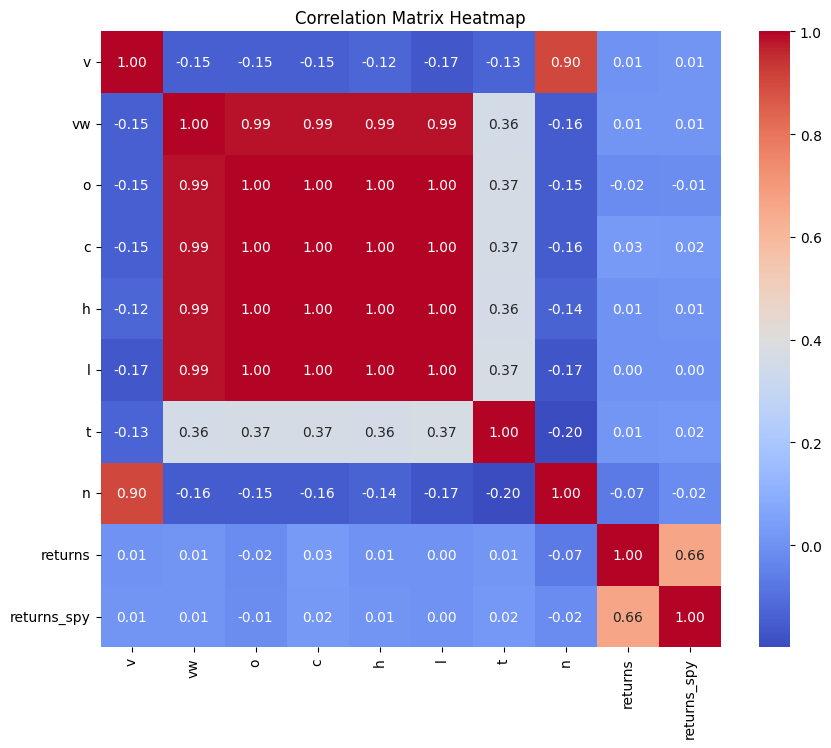

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

#Polygon Documentation: https://polygon.io/docs/stocks/get_v2_aggs_ticker__stocksticker__range__multiplier___timespan___from___to 
column_values = {'c': 'close_price', 'h': 'highest_price', 'l': 'lowest_price', 'n': 'num_transactions', 
                 'o': 'open_price', 't': 'UNIX_time_stamp', 'v': 'volume', 'vw': 'volume_weighted'}

nvda = pd.DataFrame(data_frames['NVDA'])
googl = pd.DataFrame(data_frames['GOOGL'])
aapl = pd.DataFrame(data_frames['AAPL'])
spy = pd.DataFrame(data_frames['SPY'])

nvda_with_spy_returns = nvda.join(spy['returns'], rsuffix='_spy')
googl_with_spy_returns = googl.join(spy['returns'], rsuffix='_spy')
aapl_with_spy_returns = aapl.join(spy['returns'], rsuffix='_spy')

correlation_matrix_nvda = nvda_with_spy_returns.corr()

plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
sns.heatmap(correlation_matrix_nvda, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

In [11]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5000 entries, 2023-01-03 09:00:00 to 2023-01-10 23:31:00
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   v        5000 non-null   float64
 1   vw       5000 non-null   float64
 2   o        5000 non-null   float64
 3   c        5000 non-null   float64
 4   h        5000 non-null   float64
 5   l        5000 non-null   float64
 6   t        5000 non-null   int64  
 7   n        5000 non-null   int64  
 8   returns  4999 non-null   float64
dtypes: float64(7), int64(2)
memory usage: 390.6 KB
None


In [12]:
df.columns

Index(['v', 'vw', 'o', 'c', 'h', 'l', 't', 'n', 'returns'], dtype='object')

In [13]:
# Define numerical columns (assuming all columns except 'returns' are features)
numerical_cols = ['v', 'vw', 'o', 'c', 'h', 'l', 't', 'n']  # Update if necessary

# Create a preprocessing pipeline for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())  # It's good practice to scale features for models like SVM or logistic regression
])

# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
    ])


In [14]:
X = df[numerical_cols]  # Features
y = df['returns'].apply(lambda x: 1 if x > 0 else 0)  # Target variable (1 if stock went up, 0 otherwise)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model pipeline
model_pipeline = make_pipeline(preprocessor, DecisionTreeClassifier(random_state=42))

# Define the grid search parameters
param_grid = {
    'decisiontreeclassifier__max_depth': [None, 10, 20, 30],
    'decisiontreeclassifier__min_samples_split': [2, 10, 20]
}

# Setup grid search
grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, scoring='accuracy')

# Fit model
grid_search.fit(X_train, y_train)

# Best model evaluation
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))

Best parameters: {'decisiontreeclassifier__max_depth': None, 'decisiontreeclassifier__min_samples_split': 10}
Best score: 0.666
              precision    recall  f1-score   support

           0       0.71      0.71      0.71       532
           1       0.67      0.67      0.67       468

    accuracy                           0.69      1000
   macro avg       0.69      0.69      0.69      1000
weighted avg       0.69      0.69      0.69      1000

